# Cluster Analysis of MLS Players using K Means Clustering and Principal Component Analysis

I recently came across this article titled [COMPARING PLAYERS: CLUSTERING AND STYLE OF PLAY](https://www.americansocceranalysis.com/home/2020/3/3/clustering) by [Sam Goldberg](https://www.americansocceranalysis.com/?author=5e260cf5e3c0a94c0a87edaa) on [American Soccer Analysis](https://www.americansocceranalysis.com/). I found it to be really interesting and decided to try to implement it myself. 

In this article, Sam talks about a phrase that many scouting directors, coaches and general managers (GMs) use while finding a new player in the transfer market. That phrase is, “I want a player that plays similar to this player.” Team budget plays a huge role in signing new players. A small-market team can't afford to buy the star players of the league. Therefore, coaches and GMs are often looking for a player that plays similarly and has similar attributes to another player, usually the one that has impressed across the league.

This is where machine learning comes into the picture. While recruiting players who play similar to the big names but also fit into the budget, using machine learning saves time and money, and provides an objective view of the player's level and style of play.

We will be using K means clustering, an unsupervised machine learning algorithm, for our purpose. K means clustering looks for patterns in the data (which are not easily visible to the naked eye) and group similar things together. Each object will be put into one of the 'K' groups (this is the 'K' in 'K means clustering'). We will talk more about how to choose a good K value in a later section.

We will also be using Principal Components Analysis (PCA) for dimensionality reduction. PCA will help us find metrics which account for the vast majority of the variation among the players. It will also help us to create new axes along which we would be able to visualise our data and the clusters it has, without compromising much with the variation that the actual data holds. This will also be discussed in detail in a later section.

For learning these machine learning concepts in an intuitive way, check out this [machine learning YouTube playlist](https://www.youtube.com/playlist?list=PLblh5JKOoLUICTaGLRoHQDuF_7q2GfuJF) by [StatQuest with Josh Starmer](https://www.youtube.com/c/joshstarmer).

Let's get into action!

## 1. Importing libraries and modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
%matplotlib inline

In [2]:
sns.set_style('darkgrid') # set the grid style for the seaborn plots

In [3]:
pd.set_option('display.float_format', lambda x: '%.5f' % x) # suppress scientific notation in pandas

## 2. Data preprocessing

In his article, Sam explains why for cluster analysis, the only position groups that should remain realistic targets are offensive ones, such as forwards, wingers, attacking midfielders, and possibly central midfielders. In his article, Sam clustered around the forwards in the MLS. I will be doing my cluster analysis around the central midfielders in the 2020 season of MLS. 

We will get our data from American Soccer Analysis (ASA). The data that I have downloaded from ASA includes:
* 2019 season Salary data of all the midfielders (the 2020 season salary details are not available yet, so the 2019 season salary details will work as an approximation)
* 2020 season xGoals data (**normalised by 96 minutes**) of all the central midfielders
* 2020 season xPass data (**normalised by 96 minutes**) of all the central midfielders
* 2020 season Goals Added data (**normalised by 96 minutes; g+ variation = raw**) of all the central midfielders

In [4]:
# read the csv datasets into pandas dataframes
salaries = pd.read_csv('salaries.csv', index_col=0)
xgoals = pd.read_csv('xGoals.csv', index_col=0)
xpass = pd.read_csv('xPass.csv', index_col=0)
goals_added = pd.read_csv('goals_added.csv', index_col=0)

#### Let's checkout out the first couple of rows and the metadata of each dataframe.

In [5]:
salaries.head(2)

,Player,Team,Season,Position,Base Salary,Guaranteed Compensation,Date
nan,Michael Bradley,TOR,2019,M,"$6,000,000","$6,500,000",2019-09-13
nan,Michael Bradley,TOR,2019,M,"$6,000,000","$6,428,571",2019-06-01


In [6]:
salaries.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 501 entries, nan to nan
Data columns (total 7 columns):
Player                     501 non-null object
Team                       501 non-null object
Season                     501 non-null int64
Position                   501 non-null object
Base Salary                501 non-null object
Guaranteed Compensation    501 non-null object
Date                       501 non-null object
dtypes: int64(1), object(6)
memory usage: 31.3+ KB


In [7]:
xgoals.head(2)

,Player,Team,Position,Minutes,Shots,SoT,G,xG,xPlace,G-xG,KeyP,A,xA,A-xA,xG+xA,PA,xPA
nan,Saphir Taïder,MTL,CM,1154,1.58000,0.42000,0.33000,0.32000,-0.06000,0.02000,1.91000,0.33000,0.21000,0.13000,0.52000,0.19000,0.17000
nan,Gadi Kinda,SKC,CM,1703,2.20000,0.73000,0.34000,0.31000,0.03000,0.02000,1.58000,0.11000,0.15000,-0.04000,0.46000,0.17000,0.18000


In [8]:
xgoals.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 55 entries, nan to nan
Data columns (total 17 columns):
Player      55 non-null object
Team        55 non-null object
Position    55 non-null object
Minutes     55 non-null int64
Shots       55 non-null float64
SoT         55 non-null float64
G           55 non-null float64
xG          55 non-null float64
xPlace      55 non-null float64
G-xG        55 non-null float64
KeyP        55 non-null float64
A           55 non-null float64
xA          55 non-null float64
A-xA        55 non-null float64
xG+xA       55 non-null float64
PA          55 non-null float64
xPA         55 non-null float64
dtypes: float64(13), int64(1), object(3)
memory usage: 7.7+ KB


In [9]:
xpass.head(2)

,Player,Team,Position,Minutes,Passes,Pass %,xPass %,Score,Per100,Distance,Vertical,Touch %
nan,Liam Fraser,TOR,CM,516,70.14000,88.3%,84.1%,2.99000,4.26000,20.45000,6.19000,4.3%
nan,Michael Bradley,TOR,CM,1382,79.88000,90.3%,87.6%,2.19000,2.74000,18.46000,5.12000,11.8%


In [10]:
xpass.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 55 entries, nan to nan
Data columns (total 12 columns):
Player      55 non-null object
Team        55 non-null object
Position    55 non-null object
Minutes     55 non-null int64
Passes      55 non-null float64
Pass %      55 non-null object
xPass %     55 non-null object
Score       55 non-null float64
Per100      55 non-null float64
Distance    55 non-null float64
Vertical    55 non-null float64
Touch %     55 non-null object
dtypes: float64(5), int64(1), object(6)
memory usage: 5.6+ KB


In [11]:
goals_added.head(2)

,Player,Team,Position,Minutes,Dribbling,Fouling,Interrupting,Passing,Receiving,Shooting,Goals Added
nan,Mark-Anthony Kaye,LAFC,CM,1424,0.06000,0.00000,0.07000,0.04000,0.07000,0.02000,0.26000
nan,Tomás Martínez,HOU,CM,400,0.02000,-0.01000,0.10000,-0.02000,0.13000,0.03000,0.25000


In [12]:
goals_added.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 55 entries, nan to nan
Data columns (total 11 columns):
Player          55 non-null object
Team            55 non-null object
Position        55 non-null object
Minutes         55 non-null int64
Dribbling       55 non-null float64
Fouling         55 non-null float64
Interrupting    55 non-null float64
Passing         55 non-null float64
Receiving       55 non-null float64
Shooting        55 non-null float64
Goals Added     55 non-null float64
dtypes: float64(7), int64(1), object(3)
memory usage: 5.2+ KB


### 2.1 Data cleaning and feature selection

##### Salaries dataframe

In [13]:
salaries.head(3)

,Player,Team,Season,Position,Base Salary,Guaranteed Compensation,Date
nan,Michael Bradley,TOR,2019,M,"$6,000,000","$6,500,000",2019-09-13
nan,Michael Bradley,TOR,2019,M,"$6,000,000","$6,428,571",2019-06-01
nan,Carlos Vela,LAFC,2019,M,"$4,500,000","$6,300,000",2019-06-01


In [14]:
salaries.set_index('Player', inplace=True) # set column 'Player' as index

In [15]:
print(type(salaries.iloc[0]['Base Salary']))
print(type(salaries.iloc[0]['Guaranteed Compensation']))

<class 'str'>
<class 'str'>


#### Since Base Salary and Guaranteed Compensation are in string format, let's convert them into more usable forms such as integer or float.

In [16]:
salaries['Base Salary'] = salaries['Base Salary'].apply(lambda salary: int(salary[1:].replace(',', '')))
salaries['Guaranteed Compensation'] = salaries['Guaranteed Compensation'].apply(lambda salary: int(salary[1:].replace(',', '')))

#### You can notice that many players have two salary rows, that's because the salary details are released twice a year. Let's keep just the latest salary details for each player in our Salaries dataframe.

In [17]:
salaries = salaries.sort_values('Date').groupby('Player').last()

#### Let's drop all the columns from the Salaries dataframe that we don't require for our analysis.

In [18]:
salaries.drop(['Team', 'Season', 'Position', 'Date'], axis = 1, inplace = True)

#### Finally, let's change the names of a few columns to make them more informative.

In [19]:
salaries.rename(columns = {'Base Salary': 'Base Salary (USD)', 'Guaranteed Compensation': 'Guaranteed Compensation (USD)'}, 
                inplace = True)

In [20]:
salaries.reset_index(inplace = True) # reset the index

In [21]:
salaries.head(3)

,Player,Base Salary (USD),Guaranteed Compensation (USD)
0,Aidan Daniels,57225,57225
1,Akeem Ward,70250,70250
2,Albert Rusnák,1800000,2001667


In [22]:
salaries_2 = salaries.copy() # create a copy of the salaries dataframe for use in the second cluster analysis

##### xGoals dataframe

In [23]:
xgoals.head(3)

,Player,Team,Position,Minutes,Shots,SoT,G,xG,xPlace,G-xG,KeyP,A,xA,A-xA,xG+xA,PA,xPA
nan,Saphir Taïder,MTL,CM,1154,1.58000,0.42000,0.33000,0.32000,-0.06000,0.02000,1.91000,0.33000,0.21000,0.13000,0.52000,0.19000,0.17000
nan,Gadi Kinda,SKC,CM,1703,2.20000,0.73000,0.34000,0.31000,0.03000,0.02000,1.58000,0.11000,0.15000,-0.04000,0.46000,0.17000,0.18000
nan,Memo Rodríguez,HOU,CM,1710,2.92000,0.90000,0.28000,0.30000,0.01000,-0.02000,1.68000,0.11000,0.15000,-0.03000,0.45000,0.17000,0.19000


In [24]:
xgoals.set_index('Player', inplace=True) # set column 'Player' as index

###### Note:

* We will do a couple of cluster analyses, with the second one being more advanced than the first one. In the first cluster analysis, we won't know what will be a good value for K, what metrics explain most of the variation in the data, and what metrics should be given more weightage for clustering. All of this will be done in the second cluster analysis. 

* For the first cluster analysis, I will be choosing metrics which I think are important for the kind of central midfielder we are looking for. This is analogous to consulting with your GM and coach about what metrics matter to us for our next recruit and then working on them. In the second cluster analysis, we will see how the 'elbow method' and PCA can help us come up with more accurate results.

* To get more details on what each metric in these dataframes means, you can refer to the [ASA Glossary of terms](https://www.americansocceranalysis.com/glossary).

#### Let's drop those columns from the xGoals dataframe that I don't require for my analysis.

In [25]:
xgoals.drop(['Position', 'Minutes', 'Shots', 'SoT', 'G', 'xG', 'xPlace', 'G-xG', 'PA', 'xPA'], axis = 1, inplace = True)

In [26]:
xgoals.reset_index(inplace=True) # reset the index

In [27]:
xgoals.head(3)

,Player,Team,KeyP,A,xA,A-xA,xG+xA
0,Saphir Taïder,MTL,1.91000,0.33000,0.21000,0.13000,0.52000
1,Gadi Kinda,SKC,1.58000,0.11000,0.15000,-0.04000,0.46000
2,Memo Rodríguez,HOU,1.68000,0.11000,0.15000,-0.03000,0.45000


In [28]:
xgoals_2 = xgoals.copy() # create a copy of the xgoals dataframe for use in the second cluster analysis

##### xPass dataframe

In [29]:
xpass.head(3)

,Player,Team,Position,Minutes,Passes,Pass %,xPass %,Score,Per100,Distance,Vertical,Touch %
nan,Liam Fraser,TOR,CM,516,70.14000,88.3%,84.1%,2.99000,4.26000,20.45000,6.19000,4.3%
nan,Michael Bradley,TOR,CM,1382,79.88000,90.3%,87.6%,2.19000,2.74000,18.46000,5.12000,11.8%
nan,Emerson Hyndman,ATL,CM,1515,51.39000,89.5%,86.0%,1.84000,3.57000,18.99000,3.60000,7.3%


In [30]:
xpass.set_index('Player', inplace=True) # set column 'Player' as index

#### Let's drop those columns from the xPass dataframe that I don't require for my analysis.

In [31]:
xpass.drop(['Team', 'Position', 'Minutes'], axis = 1, inplace = True)

In [32]:
print(type(xpass.iloc[0]['Pass %']))
print(type(xpass.iloc[0]['xPass %']))
print(type(xpass.iloc[0]['Touch %']))

<class 'str'>
<class 'str'>
<class 'str'>


#### Since Pass %, xPass % and Touch % are in string format, let's convert them into float values so that they can be used properly by the clustering algorithm.

In [33]:
xpass['Pass %'] = xpass['Pass %'].apply(lambda x: float(x[:-1]))
xpass['xPass %'] = xpass['xPass %'].apply(lambda x: float(x[:-1]))
xpass['Touch %'] = xpass['Touch %'].apply(lambda x: float(x[:-1]))

In [34]:
xpass.reset_index(inplace=True) # reset the index

In [35]:
xpass.head(3)

,Player,Passes,Pass %,xPass %,Score,Per100,Distance,Vertical,Touch %
0,Liam Fraser,70.14000,88.30000,84.10000,2.99000,4.26000,20.45000,6.19000,4.30000
1,Michael Bradley,79.88000,90.30000,87.60000,2.19000,2.74000,18.46000,5.12000,11.80000
2,Emerson Hyndman,51.39000,89.50000,86.00000,1.84000,3.57000,18.99000,3.60000,7.30000


In [36]:
xpass_2 = xpass.copy() # create a copy of the xpass dataframe for use in the second cluster analysis

##### Goals Added (g+) dataframe

In [37]:
goals_added.head(3)

,Player,Team,Position,Minutes,Dribbling,Fouling,Interrupting,Passing,Receiving,Shooting,Goals Added
nan,Mark-Anthony Kaye,LAFC,CM,1424,0.06000,0.00000,0.07000,0.04000,0.07000,0.02000,0.26000
nan,Tomás Martínez,HOU,CM,400,0.02000,-0.01000,0.10000,-0.02000,0.13000,0.03000,0.25000
nan,Alejandro Bedoya,PHI,CM,2395,0.02000,-0.01000,0.07000,0.07000,0.07000,0.02000,0.24000


In [38]:
goals_added.set_index('Player', inplace=True) # set column 'Player' as index

###### Note:

As of now, I am omitting all the constituent action categories for goals added. I will simply use the final g+ value for the first cluster analysis, although it will interesting to see if some action categories expain the variation among central midfielders more than others. We will include these action categories in the second cluster analysis.

#### Let's drop those columns from the g+ dataframe that we don't need for our first cluster analysis.

In [39]:
goals_added.drop(['Team', 'Position', 'Minutes'], axis = 1, inplace = True)

In [40]:
goals_added_2 = goals_added.copy() # create a copy of the goals_added dataframe for use in the second cluster analysis

In [41]:
# drop the action categories for the first cluster analysis
goals_added.drop(['Dribbling', 'Fouling', 'Interrupting', 'Passing', 'Receiving', 'Shooting'], axis = 1, inplace = True)

In [42]:
goals_added.reset_index(inplace=True) # reset the index

In [43]:
goals_added.head(3)

,Player,Goals Added
0,Mark-Anthony Kaye,0.26000
1,Tomás Martínez,0.25000
2,Alejandro Bedoya,0.24000


#### Let's merge these dataframes into a single dataframe which we will further use for our first cluster analysis.

In [44]:
df = pd.merge(left=xgoals, right=xpass, how='inner', on='Player')
df = pd.merge(left=df, right=goals_added, how='inner', on='Player')
df = pd.merge(left=df, right=salaries, how='left', on='Player')

In [45]:
df.head(3)

,Player,Team,KeyP,A,xA,A-xA,xG+xA,Passes,Pass %,xPass %,Score,Per100,Distance,Vertical,Touch %,Goals Added,Base Salary (USD),Guaranteed Compensation (USD)
0,Saphir Taïder,MTL,1.91000,0.33000,0.21000,0.13000,0.52000,60.48000,84.30000,82.70000,0.98000,1.62000,20.58000,2.37000,12.00000,0.19000,1400000.00000,1400000.00000
1,Gadi Kinda,SKC,1.58000,0.11000,0.15000,-0.04000,0.46000,40.87000,79.00000,78.60000,0.18000,0.45000,17.89000,3.53000,7.40000,0.24000,nan,nan
2,Memo Rodríguez,HOU,1.68000,0.11000,0.15000,-0.03000,0.45000,35.65000,76.40000,75.30000,0.39000,1.09000,21.15000,3.53000,6.80000,0.23000,70250.00000,82750.00000


### 2.2 Handling missing values and categorical values

#### Let's check if our dataframe has any missing values.

In [46]:
df.isnull().sum()

Player                            0
Team                              0
KeyP                              0
A                                 0
xA                                0
A-xA                              0
xG+xA                             0
Passes                            0
Pass %                            0
xPass %                           0
Score                             0
Per100                            0
Distance                          0
Vertical                          0
Touch %                           0
Goals Added                       0
Base Salary (USD)                29
Guaranteed Compensation (USD)    29
dtype: int64

In [47]:
df[df.isnull().any(axis=1)]

,Player,Team,KeyP,A,xA,A-xA,xG+xA,Passes,Pass %,xPass %,Score,Per100,Distance,Vertical,Touch %,Goals Added,Base Salary (USD),Guaranteed Compensation (USD)
1,Gadi Kinda,SKC,1.58000,0.11000,0.15000,-0.04000,0.46000,40.87000,79.00000,78.60000,0.18000,0.45000,17.89000,3.53000,7.40000,0.24000,nan,nan
5,José Cifuentes,LAFC,1.91000,0.15000,0.21000,-0.06000,0.33000,54.64000,81.40000,81.80000,-0.22000,-0.39000,18.30000,4.39000,7.10000,0.20000,nan,nan
8,Júnior Urso,ORL,0.57000,0.09000,0.11000,-0.02000,0.30000,39.82000,87.30000,86.10000,0.47000,1.18000,18.31000,2.28000,7.10000,0.14000,nan,nan
14,Bryce Duke,LAFC,1.93000,0.00000,0.17000,-0.17000,0.19000,59.72000,76.90000,80.80000,-2.34000,-3.92000,15.42000,0.08000,2.90000,-0.06000,nan,nan
15,Samuel Piette,MTL,0.96000,0.04000,0.10000,-0.06000,0.19000,40.78000,80.50000,82.00000,-0.63000,-1.55000,19.35000,4.12000,8.40000,0.14000,nan,nan
16,Francisco Ginella,LAFC,1.07000,0.21000,0.14000,0.07000,0.18000,57.03000,82.10000,83.00000,-0.54000,-0.94000,17.42000,4.64000,5.30000,0.14000,nan,nan
21,Darwin Cerén,HOU,0.81000,0.12000,0.06000,0.05000,0.14000,47.34000,83.80000,84.40000,-0.30000,-0.62000,20.64000,4.16000,8.30000,0.14000,nan,nan
23,Cameron Duke,SKC,1.75000,0.00000,0.10000,-0.10000,0.13000,20.60000,74.60000,77.70000,-0.65000,-3.14000,14.22000,1.91000,2.20000,0.09000,nan,nan
25,Emanuel Maciel,MTL,0.96000,0.32000,0.11000,0.21000,0.12000,51.15000,81.80000,85.10000,-1.66000,-3.24000,21.65000,4.89000,8.40000,0.07000,nan,nan
27,Dru Yearwood,NYRB,0.68000,0.00000,0.09000,-0.09000,0.11000,39.14000,72.80000,77.90000,-2.00000,-5.10000,19.64000,6.59000,5.30000,0.01000,nan,nan


Okay, so we have 29 players with only the salary details missing. This should not be a problem for us as we will not be giving salary details as input to our machine learning model. Salary details are present in the dataset to help GMs and coaches to find players within their budgets. We will use salary details later. If needed, we will handle these missing salary data.

We also have categorical values in the Teams column. But, as we will not give team names as input to the model, we don't need to handle these categorical values. This is purely for informational purpose, which might help the GMs and the coaches later.

### 2.3 Feature scaling

You might have across this situation during your school days where you have different subjects with different scoring scales. I remember having a subject which had scoring done on a scale of 10, while other subjects had scorings on a scale of 100. Even though an '8 out of 10' and an '80 out of 100' would eventually lead to the same grade on the transcript, many thought that an '8 out of 10' is much better than an '80 out of 100' - which clearly shows how influencial a larger scale was compared to a smaller one.

Something similar happens in machine learning as well. A very common example is a dataset with age and salary data. The age data has a very small-scaled range compared to that of salary data. Age is in multiples of tens whereas salary is in multiples of thousands. This is not good for a machine learning model as it will be more influenced by the metric which has a dominantly larger scale.

This is where feature scaling comes into the picture. Feature scaling involves using a scaling technique (there are different scaling techniques) on your data so that all the metrics have values on the same scale. 

In our dataframe as well, you can see that not all metrics are on the same scale. For example, the number of passes are mostly in multiples of tens whereas the assists per 96 metric has values on a much smaller scale. For our cluster analysis, we will use standardisation. Standardisation removes the mean (mean = 0) and scales the data to unit variance (variance = 1).

#### Before any kind of feature scaling, let's first create a dataframe that will contain only those metric values which we will give as input to the clustering algorithm.

In [48]:
data = df.drop(['Player', 'Team', 'Base Salary (USD)', 'Guaranteed Compensation (USD)'], axis=1)

In [49]:
data.head(3)

,KeyP,A,xA,A-xA,xG+xA,Passes,Pass %,xPass %,Score,Per100,Distance,Vertical,Touch %,Goals Added
0,1.91000,0.33000,0.21000,0.13000,0.52000,60.48000,84.30000,82.70000,0.98000,1.62000,20.58000,2.37000,12.00000,0.19000
1,1.58000,0.11000,0.15000,-0.04000,0.46000,40.87000,79.00000,78.60000,0.18000,0.45000,17.89000,3.53000,7.40000,0.24000
2,1.68000,0.11000,0.15000,-0.03000,0.45000,35.65000,76.40000,75.30000,0.39000,1.09000,21.15000,3.53000,6.80000,0.23000


#### Now, let's perform feature scaling using the standardisation technique.

In [50]:
scaler = StandardScaler()
scaler.fit(data) # compute the mean and standard deviation to be used for later scaling

StandardScaler(copy=True, with_mean=True, with_std=True)

In [51]:
scaled_features = scaler.transform(data) # perform standardisation by centering and scaling

In [52]:
scaled_data = pd.DataFrame(data=scaled_features, columns=data.columns) # store the scaled features in a dataframe

In [53]:
scaled_data.head(3)

,KeyP,A,xA,A-xA,xG+xA,Passes,Pass %,xPass %,Score,Per100,Distance,Vertical,Touch %,Goals Added
0,1.96137,3.41649,2.38713,2.40621,2.96458,1.19804,0.29385,-0.02450,0.89759,0.69789,0.68121,-0.47937,1.93412,0.87315
1,1.39216,0.73385,1.39500,-0.41310,2.49492,-0.38382,-0.71389,-0.81380,0.13940,0.21432,-0.63503,-0.05430,0.31328,1.57525
2,1.56465,0.73385,1.39500,-0.24726,2.41664,-0.80490,-1.20826,-1.44909,0.33843,0.47884,0.96011,-0.05430,0.10186,1.43483


## 3. K means clustering (first cluster analysis)

### 3.1 K means cluster creation

#### For the first cluster analysis, I think having three clusters of central midfielders will be a good idea. In the second cluster analysis, we will use the 'elbow method' to figure out what value of K we should be using. 

#### First of all, let's create an instance of a K means model with three clusters.

In [54]:
kmeans = KMeans(n_clusters=3)

#### Now, let's fit the model to the scaled data.

In [55]:
kmeans.fit(X=scaled_data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

###### Note:
For those of you who know how this algorithm works under the hood, we have set the maximum number of iterations of the k-means algorithm for a single run to the default value of 300. And, we have set the number of time the k-means algorithm will be run with different centroid seeds to the default value of 10. The final results will be the best output of these 10 consecutive runs in terms of inertia.

#### Let's see the cluster labels that have been assigned to the 55 central midfielders and then add these labels to the df dataframe.

In [56]:
kmeans.labels_

array([2, 2, 2, 2, 2, 2, 2, 2, 1, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 2, 0, 1,
       0, 0, 2, 2, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0])

In [57]:
len(kmeans.labels_)

55

In [58]:
df['Cluster Label'] = kmeans.labels_ # add cluster labels for players as a new column to the df dataframe

In [59]:
df.head(3)

,Player,Team,KeyP,A,xA,A-xA,xG+xA,Passes,Pass %,xPass %,Score,Per100,Distance,Vertical,Touch %,Goals Added,Base Salary (USD),Guaranteed Compensation (USD),Cluster Label
0,Saphir Taïder,MTL,1.91000,0.33000,0.21000,0.13000,0.52000,60.48000,84.30000,82.70000,0.98000,1.62000,20.58000,2.37000,12.00000,0.19000,1400000.00000,1400000.00000,2
1,Gadi Kinda,SKC,1.58000,0.11000,0.15000,-0.04000,0.46000,40.87000,79.00000,78.60000,0.18000,0.45000,17.89000,3.53000,7.40000,0.24000,nan,nan,2
2,Memo Rodríguez,HOU,1.68000,0.11000,0.15000,-0.03000,0.45000,35.65000,76.40000,75.30000,0.39000,1.09000,21.15000,3.53000,6.80000,0.23000,70250.00000,82750.00000,2


### 3.2 Analysis and observations

#### Let's check out all the three clusters and the players they include.

In [60]:
cluster_0 = df[df['Cluster Label']==0]['Player']
cluster_1 = df[df['Cluster Label']==1]['Player']
cluster_2 = df[df['Cluster Label']==2]['Player']

In [61]:
print('\nCluster 0 players:\n')
print(cluster_0)
print('\n\n')
print('Cluster 1 players:\n')
print(cluster_1)
print('\n\n')
print('Cluster 2 players:\n')
print(cluster_2)


Cluster 0 players:

9           Roger Espinoza
10           Eric Calvillo
12             Amar Sejdic
13          Tomás Martínez
14              Bryce Duke
15           Samuel Piette
18       Cristhian Paredes
20           Boniek García
22        Felipe Hernandez
23            Cameron Duke
27            Dru Yearwood
29    Cristian Cásseres Jr
33              Sean Davis
37       Michael Baldisimo
44            Moses Nyeman
54            Noble Okello
Name: Player, dtype: object



Cluster 1 players:

8          Júnior Urso
21        Darwin Cerén
26      Jackson Yueill
28     Emerson Hyndman
30       Matt LaGrassa
31       Leonard Owusu
32       Frankie Amaya
34     Luka Stojanovic
35        Fatai Alashe
36     Michael Bradley
38    Matheus Rossetto
39         Joey Dezart
40     Russell Teibert
41    Tah Brian Anunga
42       Júnior Moreno
43        Mohammed Abu
45         Luis Felipe
46         Liam Fraser
47       Carlos Harvey
48        Caleb Stanko
49     Justin Portillo
50    Patrick

#### Let's have a look at the average values of all the metrics for these three clusters.

In [62]:
cluster_0_avg = df[df['Cluster Label']==0].mean()
cluster_1_avg = df[df['Cluster Label']==1].mean()
cluster_2_avg = df[df['Cluster Label']==2].mean()

In [63]:
# create a dataframe containing the average metric values for the three clusters
avg_metric_values = pd.DataFrame(
    {'cluster 0 avg': cluster_0_avg, 
     'cluster 1 avg': cluster_1_avg, 
     'cluster 2 avg': cluster_2_avg}
)

In [64]:
avg_metric_values

,cluster 0 avg,cluster 1 avg,cluster 2 avg
KeyP,0.77375,0.40040,1.43714
A,0.01063,0.01440,0.15786
xA,0.06000,0.02520,0.14429
A-xA,-0.04938,-0.01080,0.01643
xG+xA,0.14187,0.05760,0.29000
Passes,41.52000,44.36680,52.57571
Pass %,77.54375,86.69200,81.67857
xPass %,79.23750,86.06800,81.14286
Score,-0.74812,0.39840,0.27286
Per100,-1.69687,0.63520,0.53571


###### Note:

I had written my initial observations after the first time the model created the clusters, but I realised soon that fitting the model to the data again might give you slightly different clusters, that is, few of the players might move to another cluster. That's why I have removed my initial observations because the very next time I ran the model, my first initial observations didn't make much sense.

## 4. Principal Component Analysis (PCA)

### 4.1 Introduction to Principal Component Analysis (PCA)

This is the beginning of our second cluster analysis. Our goal from the start has been to group similar central midfielders into clusters. The best way to do this is to find meaningful metrics which would help us diffentiate between players very clearly, as well as assess their desirable attributes. Therefore, we have to look for metrics which account for the majority of the variation among the players. 

So, we have to select metrics which explain most of the variation in the data, omit the ones which don't, and also ensure that we take into account the metrics that our GM and the coach have suggested. All of these have to be done very carefully. We saw in our first cluster analysis that I selected metrics completely based on my requirements, and I dropped the other metrics. The results we got were good but we can do better. First of all, let's see what could have been some of the issues with our first cluster analysis:

* I didn't consider the variation associated with each metric. This means that I might have omitted some metrics which could have helped us cluster the players more accurately.
* Of all the metrics I selected, not all of them accounted for a lot of the variation observed in the data. Let's have a look at the standard deviations (square roots of the variations) of the metrics we gave as input to the K means clustering model:

In [65]:
data.describe().loc['std']

KeyP           0.58509
A              0.08276
xA             0.06103
A-xA           0.06085
xG+xA          0.12893
Passes        12.51103
Pass %         5.30774
xPass %        5.24236
Score          1.06487
Per100         2.44180
Distance       2.06254
Vertical       2.75412
Touch %        2.86419
Goals Added    0.07187
Name: std, dtype: float64

As you can see, metrics such as Touch % and Pass % have higher standard deviations (therefore, higher variances) than metrics such as KeyP and Goals Added. Does that mean we should omit these metrics which explain little variation observed in the data? Doing that will again make us run into the risk of dropping important information that might help us in clustering the players.

It seems that there's a better way to perform cluster analysis, that is to keep all the metrics that we want to assess but to give each metric some weight (that is, a level of importance) based on how much variation it accounts for. This is exactly what Principal Component Analysis (PCA) does. 

PCA is a dimensionality reduction technique. It creates new features/metrics using linear combinations of the original features/metrics, that is, it gives a weight to each of the original metrics based on how much variation they explain. It combines these weighted metrics and forms a new feature. In this way, PCA keeps takes into account all the initial metrics but it also gives certain weightage to each of those.

These new features form the axes of the PCA plot and are known as Principal Components (PCs). In most of the cases, the first two PCs account for the vast majority of the variation that is observed in the data. Therefore, PC1 and PC2 can provide a really good approximation of the variation in the data for our cluster analysis. Also, the variation observed on the PC1 axis is more significant than the variation observed on the PC2 axis. Visualising the variation in the data also becomes very easy as PCA can reduce the dimensionality to two or three dimensions, without any significant loss of variation.

For more details and a much intuitive explanation, checkout the [StatQuest on Principal Component Analysis (PCA)](https://www.youtube.com/watch?v=FgakZw6K1QQ).

Okay, now let's see PCA in action. Hopefully, we will perform a more accurate cluster analysis this time.

#### Let's create a dataframe to be used for the second cluster analysis.

In [66]:
# rename columns to make them more informative
goals_added_2.rename(columns = {'Dribbling': 'Dribbling (g+)', 'Fouling': 'Fouling (g+)', 'Interrupting': 'Interrupting (g+)',
                    'Passing': 'Passing (g+)', 'Receiving': 'Receiving (g+)', 'Shooting': 'Shooting (g+)'}, inplace=True)

goals_added_2.reset_index(inplace=True) # reset the index

# merge the dataframes created for the second cluster analysis
df_2 = pd.merge(left=xgoals_2, right=xpass_2, how='inner', on='Player')
df_2 = pd.merge(left=df_2, right=goals_added_2, how='inner', on='Player')
df_2 = pd.merge(left=df_2, right=salaries_2, how='left', on='Player')

In [67]:
df_2.head(3)

,Player,Team,KeyP,A,xA,A-xA,xG+xA,Passes,Pass %,xPass %,...,Touch %,Dribbling (g+),Fouling (g+),Interrupting (g+),Passing (g+),Receiving (g+),Shooting (g+),Goals Added,Base Salary (USD),Guaranteed Compensation (USD)
0,Saphir Taïder,MTL,1.91000,0.33000,0.21000,0.13000,0.52000,60.48000,84.30000,82.70000,...,12.00000,-0.00000,-0.00000,0.06000,0.06000,0.06000,0.01000,0.19000,1400000.00000,1400000.00000
1,Gadi Kinda,SKC,1.58000,0.11000,0.15000,-0.04000,0.46000,40.87000,79.00000,78.60000,...,7.40000,0.02000,0.00000,0.06000,-0.00000,0.12000,0.04000,0.24000,nan,nan
2,Memo Rodríguez,HOU,1.68000,0.11000,0.15000,-0.03000,0.45000,35.65000,76.40000,75.30000,...,6.80000,0.03000,0.03000,0.05000,-0.00000,0.07000,0.05000,0.23000,70250.00000,82750.00000


#### Now, let's create a dataframe which will contain only those metric values which will be given as input to the PCA algorithm. Subsequently, we will apply feature scaling to this data.

In [68]:
data_2 = df_2.drop(['Player', 'Team', 'Base Salary (USD)', 'Guaranteed Compensation (USD)'], axis=1)

In [69]:
data_2.head(3)

,KeyP,A,xA,A-xA,xG+xA,Passes,Pass %,xPass %,Score,Per100,Distance,Vertical,Touch %,Dribbling (g+),Fouling (g+),Interrupting (g+),Passing (g+),Receiving (g+),Shooting (g+),Goals Added
0,1.91000,0.33000,0.21000,0.13000,0.52000,60.48000,84.30000,82.70000,0.98000,1.62000,20.58000,2.37000,12.00000,-0.00000,-0.00000,0.06000,0.06000,0.06000,0.01000,0.19000
1,1.58000,0.11000,0.15000,-0.04000,0.46000,40.87000,79.00000,78.60000,0.18000,0.45000,17.89000,3.53000,7.40000,0.02000,0.00000,0.06000,-0.00000,0.12000,0.04000,0.24000
2,1.68000,0.11000,0.15000,-0.03000,0.45000,35.65000,76.40000,75.30000,0.39000,1.09000,21.15000,3.53000,6.80000,0.03000,0.03000,0.05000,-0.00000,0.07000,0.05000,0.23000


In [70]:
# feature scaling using standardisation technique

scaler = StandardScaler()
scaler.fit(data_2) # compute the mean and standard deviation to be used for later scaling
scaled_features = scaler.transform(data_2) # perform standardisation by centering and scaling

### 4.2 Implementing PCA

#### Let's instantiate a PCA object first.

###### Note:

* For our second cluster analysis, we will find and use the first two PCs. In most cases, PC1 and PC2 account for the vast majority of the variation in the data (we will find out the exact proportion of variation that each of the two PCs account for in our case). 

* We will also use the loading scores (loading scores are the weights assigned to each of the initial metrics) of PC1 to see which of the initial metrics explain a lot of the variation in the data. The metrics with higher loading scores or weights are the ones which help differentiate and cluster players better. 

* Furthermore, we will use K means clustering on these new features produced by PCA to cluster the central midfielders. We will also use the 'elbow method' to find a suitable value for the number of clusters (K).

In [71]:
pca = PCA(n_components=2)

#### Now, we will find the PCs using the fit method.

In [72]:
pca.fit(scaled_features)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

#### Let's apply rotation and dimensionality reduction to transform the data to its first two PCs.

In [73]:
pca_data = pca.transform(scaled_features)

#### Earlier, it was difficult to visualise our data since had multiple dimensions (more than three). PCA helped us bring this high dimensional data to the two-dimensional space. Let's plot our data!

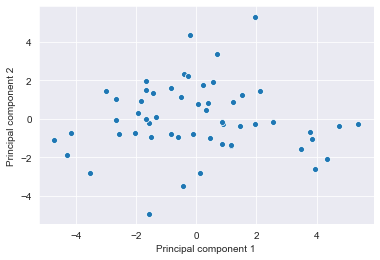

In [74]:
sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1])
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')
plt.show()

Variation observed along the PC1 axis is more significant than the variation observed along the PC2 axis. We will plot this data again after we perform clustering on this PCA data. 

### 4.3 Interpreting the components

Remember we talked about how PCA assigns weights to the original metrics based on how much variation each can explain? Let's have a look at the metrics which were the most important in affecting which cluster a player was assigned to.

#### Earlier, we had decided to use only the loading scores of PC1 to analyse the metrics. Let's quickly build a dataframe for the same and observe the results.

In [75]:
pc1_loading_scores = pd.DataFrame(data=pca.components_[0], index=data_2.columns, columns=['PC1 Loading Score'])
pc1_loading_scores.sort_values(by='PC1 Loading Score', ascending=False, inplace=True)

In [76]:
pc1_loading_scores

,PC1 Loading Score
xG+xA,0.35571
xA,0.33960
Goals Added,0.33748
KeyP,0.31984
A,0.29820
Passing (g+),0.28217
Shooting (g+),0.26214
Touch %,0.26213
Vertical,0.20701
Passes,0.19011


Let's analyse the loading scores:

* In the first cluster analysis, I had included Pass % and xPass %. Here, we can see that these two metrics don't explain much of the variation in the data. Nervertheless, we can still include these in our cluster analysis if this is something we really want to assess. It's just that these metrics don't explain much when it comes to the variation in our data.


* I can do my second cluster analysis in several ways:
 * I can discuss these metrics and the associated loading scores with my coach and GM, and then we can select the ones which explain a significant amount of variation in our data. This will help us cluster our players better. We can also include metrics which we think we need to assess, even if they don't explain much of the variation.
 * I can use these new features created through PCA to cluster the players. Since the new PCA data is two-dimensional, we can easily visualise the data. Moreover, these new features are linear combinations of the original metrics, which means that we are taking into account all of the original metrics - with weights assigned to them based on the amount of variation they explain.
 * I can also ask the front office and technical staff about their requirements, perform PCA on the selected metrics, and cluster players based on the PCA data.


* Selecting metrics for cluster analysis requires thorough discussion with the people involved in player recruitment. Proper use of PCA or any other dimensionality reduction technique to find the metrics which can help cluster the players better, along with determining the metrics that we would like to assess our targets on leads to a more accurate analysis. Expert opinions of the front office and the results of clustering and dimensionality reduction can together help recruit players according to the team's needs.
 
Sam Goldberg explained this process really well in his article:
> Like all machine learning and data analysis, clustering is dependent on the needs of your team. Communication of goals needs to occur or else clustering can only maintain a generic, topline level of usefulness rather than being specific to the needs of the club.

## 5. K means clustering (second cluster analysis)

For the second cluster analysis, I have decided to use the two-dimensional data obtained from PCA. 

### 5.1 Data

#### Let's first create a dataframe for the PCA data.

In [77]:
pca_df = pd.DataFrame(data=pca_data, index=df_2['Player'], columns=['PC 1', 'PC 2'])
pca_df.reset_index(inplace=True) # reset the index

In [78]:
pca_df.head(3)

,Player,PC 1,PC 2
0,Saphir Taïder,5.37261,-0.25164
1,Gadi Kinda,3.93935,-2.63560
2,Memo Rodríguez,4.33151,-2.09262


### 5.2 Elbow method

We know that our clusters are significantly accurate when the variation within each cluster is as little as possible. Each time we add a new cluster, the total variation within each cluster is smaller than before. And when there is only one point per cluster, the variation is 0.

The inertia attribute of a K means clustering model represents the sum of squared distances of samples to their closest cluster center. Sum of squared distances is a measure of variation.

Even though more number of clusters means a smaller variation, our decision of selecting a suitable K value should not completely rely on this fact. Having a number of clusters more than is required defeats the whole purpose of clustering. 

If we plot the inertia per value of K, we will notice that after a certain K value, the inertia doesn't decrease as quickly as it did before. This K value is called the 'elbow point' sometimes, and it is a suitable value for K in our K means clustering analysis.

Let's apply the elbow method and find a suitable K value for our cluster analysis!

#### First of all, we will scale the PCA data.

In [79]:
# feature scaling using standardisation technique

scaler = StandardScaler()
scaler.fit(pca_df.drop('Player', axis=1)) # compute the mean and standard deviation to be used for later scaling
scaled_pca_features = scaler.transform(pca_df.drop('Player', axis=1)) # perform standardisation by centering and scaling
scaled_pca_data = pd.DataFrame(data=scaled_pca_features, columns=pca_df.drop('Player', axis=1).columns) # store the scaled features in a datafram

#### Prior to applying the elbow method, we have to decide a range of possible number of clusters. For our cluster analysis, let's take a range of 1 to 10 and see the results.

In [80]:
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X=scaled_pca_data)
    inertia.append(kmeans.inertia_)
elbow_df = pd.DataFrame({'Number of clusters':range(1, 11), 'Inertia':inertia})

#### Here's the elbow plot:

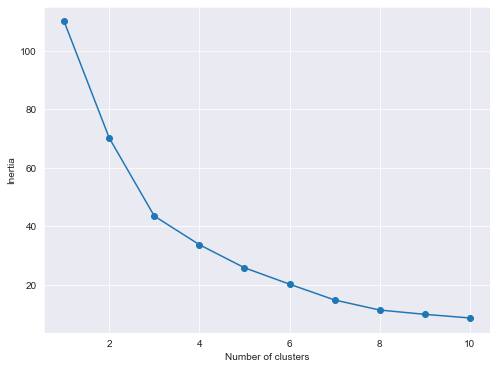

In [81]:
plt.figure(figsize=(8,6))
plt.plot(elbow_df['Number of clusters'], elbow_df['Inertia'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

If you observe carefully, the inertia value drops quickly from K=1 to K=3. After K=3, the inertia value decreases slowly (that is, the inertia value doesn't decrease much as K increases from 3 to 10). This sharp point (like the elbow) at K=3 is called the elbow point. Therefore, a suitable K value for our cluster analysis will be 3. Having more than 3 clusters doesn't significantly explain the variation in the data.

### 5.3 K means cluster creation

#### Let's apply the K means clustering algorithm to our scaled PCA data and create 3 clusters.

In [82]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(X=scaled_pca_data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

#### Now, we will check out the cluster labels that have been assigned to the 55 central midfielders and then add these labels to the pca_df dataframe.

In [83]:
kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 2, 1, 2, 1, 2,
       1, 1, 2, 0, 2, 1, 2, 2, 2, 1, 1, 2, 1, 1, 2, 2, 1, 1, 2, 2, 2, 2,
       1, 1, 2, 2, 1, 2, 2, 2, 1, 1, 2])

In [84]:
len(kmeans.labels_)

55

In [85]:
pca_df['Cluster Label'] = kmeans.labels_ # add cluster labels for players as a new column to the pca_df dataframe

In [86]:
pca_df.head(3)

,Player,PC 1,PC 2,Cluster Label
0,Saphir Taïder,5.37261,-0.25164,0
1,Gadi Kinda,3.93935,-2.63560,0
2,Memo Rodríguez,4.33151,-2.09262,0


### 5.4 Analysis and visualisation

#### First of all, let's plot the clusters.

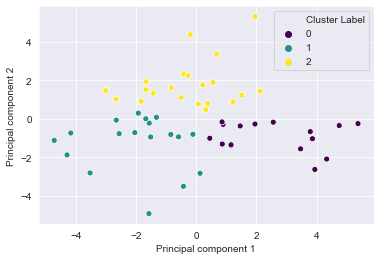

In [87]:
sns.scatterplot(x='PC 1', y='PC 2', data=pca_df, hue='Cluster Label', palette='viridis')
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')
plt.show()

Here, you can see that all the players have been clustered very nicely. PCA made it possible for us to visualise the clusters.

#### Now, let's check out all the three clusters and the players they include.

In [88]:
pca_cluster_0 = pca_df[pca_df['Cluster Label']==0]['Player']
pca_cluster_1 = pca_df[pca_df['Cluster Label']==1]['Player']
pca_cluster_2 = pca_df[pca_df['Cluster Label']==2]['Player']

In [89]:
print('\nCluster 0 players:\n')
print(pca_cluster_0)
print('\n\n')
print('Cluster 1 players:\n')
print(pca_cluster_1)
print('\n\n')
print('Cluster 2 players:\n')
print(pca_cluster_2)


Cluster 0 players:

0         Saphir Taïder
1            Gadi Kinda
2        Memo Rodríguez
3       Jamiro Monteiro
4     Mark-Anthony Kaye
5        José Cifuentes
6        Sacha Kljestan
7      Alejandro Bedoya
8           Júnior Urso
9        Roger Espinoza
11       Latif Blessing
12          Amar Sejdic
13       Tomás Martínez
15        Samuel Piette
16    Francisco Ginella
25       Emanuel Maciel
Name: Player, dtype: object



Cluster 1 players:

10        Eric Calvillo
14           Bryce Duke
18    Cristhian Paredes
20        Boniek García
22     Felipe Hernandez
23         Cameron Duke
27         Dru Yearwood
31        Leonard Owusu
32        Frankie Amaya
34      Luka Stojanovic
35         Fatai Alashe
38     Matheus Rossetto
39          Joey Dezart
44         Moses Nyeman
45          Luis Felipe
48         Caleb Stanko
52          Tyler Wolff
53          Luis Argudo
Name: Player, dtype: object



Cluster 2 players:

17                  Felipe
19           Hwang In-Beom
21     

Our second cluster analysis is certainly more accurate than our first one. Also, running the K means clustering algorithm again and again on our scaled PCA data doesn't change the clusters.

## 6. Results

We are almost done with our second cluster analysis. The only thing left is to prepare one final dataset/dataframe that we'll give to the team staff concerned with recruitment. This final dataset will be helpful to them during the recruitment process and all other relevant activities. We will keep only those metrics in this final dataset that the front office staff wants to see (in our case, the metrics that I want to see).

Let's do this!

In [90]:
df_2.columns

Index(['Player', 'Team', 'KeyP', 'A', 'xA', 'A-xA', 'xG+xA', 'Passes',
       'Pass %', 'xPass %', 'Score', 'Per100', 'Distance', 'Vertical',
       'Touch %', 'Dribbling (g+)', 'Fouling (g+)', 'Interrupting (g+)',
       'Passing (g+)', 'Receiving (g+)', 'Shooting (g+)', 'Goals Added',
       'Base Salary (USD)', 'Guaranteed Compensation (USD)'],
      dtype='object')

In [91]:
final_data = pd.merge(left=pca_df[['Player', 'Cluster Label']],
                      right=df_2.drop(['Distance', 'Vertical', 'Fouling (g+)', 'Interrupting (g+)', 'Shooting (g+)'], axis=1),
                      how='inner', on='Player')

In [92]:
final_data.head(3)

,Player,Cluster Label,Team,KeyP,A,xA,A-xA,xG+xA,Passes,Pass %,xPass %,Score,Per100,Touch %,Dribbling (g+),Passing (g+),Receiving (g+),Goals Added,Base Salary (USD),Guaranteed Compensation (USD)
0,Saphir Taïder,0,MTL,1.91000,0.33000,0.21000,0.13000,0.52000,60.48000,84.30000,82.70000,0.98000,1.62000,12.00000,-0.00000,0.06000,0.06000,0.19000,1400000.00000,1400000.00000
1,Gadi Kinda,0,SKC,1.58000,0.11000,0.15000,-0.04000,0.46000,40.87000,79.00000,78.60000,0.18000,0.45000,7.40000,0.02000,-0.00000,0.12000,0.24000,nan,nan
2,Memo Rodríguez,0,HOU,1.68000,0.11000,0.15000,-0.03000,0.45000,35.65000,76.40000,75.30000,0.39000,1.09000,6.80000,0.03000,-0.00000,0.07000,0.23000,70250.00000,82750.00000


There's still one issue with this data that is needed to be resolved. Do you remember that we had found 29 players in our dataset who didn't have any salary details? We need to fill those missing salary details now.

A good approximation would be to use the average base salary and average guaranteed compensation values of each cluster. For each player who doesn't have his salary details, we can fill those with the average salary details of the cluster he belongs to. I agree that this might not be the best way to deal with and handle these missing values, but this might give the GM and the front office staff some idea about how much these players might cost to them. 

#### We will now fill the missing base salary and guaranteed compensation values.

In [93]:
final_data['Base Salary (USD)'] = final_data[['Base Salary (USD)', 'Cluster Label']].groupby('Cluster Label').transform(lambda x: x.fillna(x.mean()))
final_data['Guaranteed Compensation (USD)'] = final_data[['Guaranteed Compensation (USD)', 'Cluster Label']].groupby('Cluster Label').transform(lambda x: x.fillna(x.mean()))

In [94]:
final_data.head(3)

,Player,Cluster Label,Team,KeyP,A,xA,A-xA,xG+xA,Passes,Pass %,xPass %,Score,Per100,Touch %,Dribbling (g+),Passing (g+),Receiving (g+),Goals Added,Base Salary (USD),Guaranteed Compensation (USD)
0,Saphir Taïder,0,MTL,1.91000,0.33000,0.21000,0.13000,0.52000,60.48000,84.30000,82.70000,0.98000,1.62000,12.00000,-0.00000,0.06000,0.06000,0.19000,1400000.00000,1400000.00000
1,Gadi Kinda,0,SKC,1.58000,0.11000,0.15000,-0.04000,0.46000,40.87000,79.00000,78.60000,0.18000,0.45000,7.40000,0.02000,-0.00000,0.12000,0.24000,576450.20000,618260.70000
2,Memo Rodríguez,0,HOU,1.68000,0.11000,0.15000,-0.03000,0.45000,35.65000,76.40000,75.30000,0.39000,1.09000,6.80000,0.03000,-0.00000,0.07000,0.23000,70250.00000,82750.00000


All the missing values have been filled successfully.

#### Let's see the cluster-wise data.

##### Cluster 0 data (sorted by guaranteed compensation in decreasing order):

In [95]:
final_data[final_data['Cluster Label'] == 0].sort_values(by='Guaranteed Compensation (USD)', ascending=False)

,Player,Cluster Label,Team,KeyP,A,xA,A-xA,xG+xA,Passes,Pass %,xPass %,Score,Per100,Touch %,Dribbling (g+),Passing (g+),Receiving (g+),Goals Added,Base Salary (USD),Guaranteed Compensation (USD)
0,Saphir Taïder,0,MTL,1.91000,0.33000,0.21000,0.13000,0.52000,60.48000,84.30000,82.70000,0.98000,1.62000,12.00000,-0.00000,0.06000,0.06000,0.19000,1400000.00000,1400000.00000
7,Alejandro Bedoya,0,PHI,1.32000,0.12000,0.19000,-0.07000,0.30000,49.98000,79.80000,78.80000,0.49000,0.98000,10.00000,0.02000,0.07000,0.07000,0.24000,1200000.00000,1266250.00000
6,Sacha Kljestan,0,LAG,1.48000,0.00000,0.16000,-0.16000,0.32000,51.86000,81.40000,79.50000,0.99000,1.90000,7.20000,0.01000,0.03000,0.04000,0.22000,1025000.00000,1100000.00000
9,Roger Espinoza,0,SKC,1.11000,0.07000,0.09000,-0.02000,0.28000,37.85000,79.00000,80.40000,-0.51000,-1.34000,5.90000,0.01000,0.01000,0.07000,0.15000,800000.00000,800000.00000
3,Jamiro Monteiro,0,PHI,2.06000,0.15000,0.18000,-0.03000,0.35000,50.12000,80.50000,79.40000,0.56000,1.13000,11.00000,-0.00000,0.03000,0.08000,0.18000,618000.00000,671200.00000
1,Gadi Kinda,0,SKC,1.58000,0.11000,0.15000,-0.04000,0.46000,40.87000,79.00000,78.60000,0.18000,0.45000,7.40000,0.02000,-0.00000,0.12000,0.24000,576450.20000,618260.70000
5,José Cifuentes,0,LAFC,1.91000,0.15000,0.21000,-0.06000,0.33000,54.64000,81.40000,81.80000,-0.22000,-0.39000,7.10000,0.03000,0.04000,0.06000,0.20000,576450.20000,618260.70000
8,Júnior Urso,0,ORL,0.57000,0.09000,0.11000,-0.02000,0.30000,39.82000,87.30000,86.10000,0.47000,1.18000,7.10000,0.01000,-0.01000,0.07000,0.14000,576450.20000,618260.70000
15,Samuel Piette,0,MTL,0.96000,0.04000,0.10000,-0.06000,0.19000,40.78000,80.50000,82.00000,-0.63000,-1.55000,8.40000,-0.01000,0.00000,0.07000,0.14000,576450.20000,618260.70000
16,Francisco Ginella,0,LAFC,1.07000,0.21000,0.14000,0.07000,0.18000,57.03000,82.10000,83.00000,-0.54000,-0.94000,5.30000,-0.01000,0.03000,0.04000,0.14000,576450.20000,618260.70000


##### Cluster 1 data (sorted by guaranteed compensation in decreasing order):

In [96]:
final_data[final_data['Cluster Label'] == 1].sort_values(by='Guaranteed Compensation (USD)', ascending=False)

,Player,Cluster Label,Team,KeyP,A,xA,A-xA,xG+xA,Passes,Pass %,xPass %,Score,Per100,Touch %,Dribbling (g+),Passing (g+),Receiving (g+),Goals Added,Base Salary (USD),Guaranteed Compensation (USD)
18,Cristhian Paredes,1,POR,0.67000,0.00000,0.03000,-0.03000,0.15000,43.28000,77.50000,80.80000,-1.41000,-3.25000,5.50000,0.03000,-0.02000,0.05000,0.14000,252000.00000,283500.00000
20,Boniek García,1,HOU,0.83000,0.00000,0.07000,-0.07000,0.15000,40.02000,81.90000,83.50000,-0.65000,-1.62000,4.70000,0.02000,0.01000,0.05000,0.16000,168000.00000,183000.00000
32,Frankie Amaya,1,CIN,0.54000,0.00000,0.02000,-0.02000,0.08000,46.44000,86.40000,87.50000,-0.53000,-1.14000,8.80000,0.01000,-0.03000,0.02000,0.10000,110000.00000,172000.00000
34,Luka Stojanovic,1,CHI,0.00000,0.00000,0.00000,0.00000,0.07000,22.36000,88.20000,90.90000,-0.59000,-2.63000,3.10000,-0.07000,-0.03000,0.05000,0.01000,127245.83333,148079.16667
48,Caleb Stanko,1,CIN,0.61000,0.00000,0.01000,-0.01000,0.01000,39.04000,85.90000,88.50000,-1.04000,-2.67000,4.40000,-0.00000,-0.04000,0.01000,0.10000,127245.83333,148079.16667
52,Tyler Wolff,1,ATL,0.00000,0.00000,0.00000,0.00000,0.00000,30.25000,82.60000,87.00000,-1.32000,-4.37000,2.10000,0.00000,-0.09000,0.02000,0.04000,127245.83333,148079.16667
23,Cameron Duke,1,SKC,1.75000,0.00000,0.10000,-0.10000,0.13000,20.60000,74.60000,77.70000,-0.65000,-3.14000,2.20000,0.00000,-0.01000,0.05000,0.09000,127245.83333,148079.16667
27,Dru Yearwood,1,NYRB,0.68000,0.00000,0.09000,-0.09000,0.11000,39.14000,72.80000,77.90000,-2.00000,-5.10000,5.30000,0.02000,-0.01000,0.01000,0.01000,127245.83333,148079.16667
31,Leonard Owusu,1,VAN,0.25000,0.00000,0.04000,-0.04000,0.08000,35.08000,85.30000,86.40000,-0.38000,-1.09000,6.60000,-0.01000,-0.02000,0.03000,0.09000,127245.83333,148079.16667
14,Bryce Duke,1,LAFC,1.93000,0.00000,0.17000,-0.17000,0.19000,59.72000,76.90000,80.80000,-2.34000,-3.92000,2.90000,-0.04000,-0.10000,0.04000,-0.06000,127245.83333,148079.16667


##### Cluster 2 data (sorted by guaranteed compensation in decreasing order):

In [97]:
final_data[final_data['Cluster Label'] == 2].sort_values(by='Guaranteed Compensation (USD)', ascending=False)

,Player,Cluster Label,Team,KeyP,A,xA,A-xA,xG+xA,Passes,Pass %,xPass %,Score,Per100,Touch %,Dribbling (g+),Passing (g+),Receiving (g+),Goals Added,Base Salary (USD),Guaranteed Compensation (USD)
36,Michael Bradley,2,TOR,0.49000,0.00000,0.02000,-0.02000,0.06000,79.88000,90.30000,87.60000,2.19000,2.74000,11.80000,0.04000,0.02000,0.02000,0.20000,6000000.00000,6500000.00000
37,Michael Baldisimo,2,VAN,0.73000,0.00000,0.04000,-0.04000,0.06000,51.83000,82.20000,82.50000,-0.18000,-0.35000,7.40000,-0.02000,-0.01000,0.02000,0.16000,836449.50000,904256.00000
42,Júnior Moreno,2,DCU,0.65000,0.05000,0.02000,0.03000,0.04000,54.47000,87.20000,84.80000,1.29000,2.38000,10.50000,0.00000,0.01000,0.01000,0.09000,836449.50000,904256.00000
21,Darwin Cerén,2,HOU,0.81000,0.12000,0.06000,0.05000,0.14000,47.34000,83.80000,84.40000,-0.30000,-0.62000,8.30000,-0.01000,-0.02000,0.03000,0.14000,836449.50000,904256.00000
51,Janio Bikel,2,VAN,0.00000,0.00000,0.00000,0.00000,0.00000,37.11000,83.10000,84.80000,-0.61000,-1.65000,7.80000,-0.00000,0.00000,0.01000,0.16000,836449.50000,904256.00000
50,Patrick Metcalfe,2,VAN,0.00000,0.00000,0.00000,0.00000,0.00000,28.52000,91.50000,86.10000,1.56000,5.46000,3.00000,-0.02000,-0.03000,0.03000,0.04000,836449.50000,904256.00000
47,Carlos Harvey,2,LAG,0.71000,0.00000,0.02000,-0.02000,0.02000,31.29000,86.40000,84.40000,0.60000,1.92000,2.20000,-0.04000,-0.00000,0.00000,0.03000,836449.50000,904256.00000
46,Liam Fraser,2,TOR,0.19000,0.00000,0.00000,-0.00000,0.02000,70.14000,88.30000,84.10000,2.99000,4.26000,4.30000,0.02000,0.04000,0.01000,0.18000,836449.50000,904256.00000
30,Matt LaGrassa,2,NSH,0.68000,0.00000,0.04000,-0.04000,0.08000,43.55000,83.30000,81.50000,0.77000,1.77000,4.80000,-0.02000,0.01000,0.05000,0.12000,836449.50000,904256.00000
43,Mohammed Abu,2,DCU,0.53000,0.00000,0.02000,-0.02000,0.03000,57.65000,86.20000,85.60000,0.35000,0.60000,7.30000,0.03000,-0.01000,0.02000,0.16000,836449.50000,904256.00000


Now, we can use this data to find central midfielders within our budget who have similar attributes and similar style of play to some of the big players who have impressed us with their skills.

Let's take an example. Suppose I am the GM of an MLS team and I want to find a player who has similar attributes to Alejandro Bedoya but I can offer a maximum guaranteed compensation of only $400,000. Firstly, I can check out the cluster Bedoya is in and find players who will fit in our budget. Then I can further analyse these targets of ours using other analytical and statistical methods. GMs, coaches and front office staff of various teams can similarly use cluster analysis to find a suitable group of targets for their team's requirements.

## 7. Limitations and Conclusion

### 7.1 Limitations

* We have used event-based data and metrics for our cluster analysis, and this explains just half of the story. Event-based data is generated through events on the field and their respective locations whereas in tracking-based data, we look at the player locations first. We don't have any tracking-based data yet. Tracking-based metrics (such as players in the line of the shot, players between the ball and the goal, line breaking passes, and more) would have helped us immensely in our analysis.


* Our goal was to cluster central midfielders, so I got the data of only those MLS players whose position has been mentioned as 'CM'. Practically, this doesn't include all the players who actually play in the centre of the midfield. There might be teams who have really fluid playing formations so players might be allowed to play freely. This is usually the case with teams who have versatile players who can take up spaces and fill the positions on the field irrespective of their positions mentioned on the paper. There also might be players who have been listed as attacking midfielders or wide or defensive midfielders but they play in the central position in their team's system. This affects our clustering process.

To drive these two points home, here's an excerpt from Sam's article where he provides a really good explanation:

> Without tracking based data, the only position groups that should remain realistic targets for cluster analysis are offensive ones, such as Forwards, Wingers, Central Attacking Midfielders, and possibly central midfielders. The difficulty level of tracking defender ability in different situations without further context, makes clustering around their true style of play very complicated. So much of being a successful defender is positioning and communication between the center backs, in addition to the relative space between the goalkeeper and the defenders. These aspects of the game are things that cannot be measured solely with event data.

* This analysis includes player data only from the 2020 season of MLS. Using data from past several seasons would have helped more as we would have been able to see general trends and find out players who have been performing well over the past few seasons. Also, it is more practical to find data from leagues all over the world. This would help us find more players and also make our clustering analysis better and more accurate. A result of this is finding non-major league players who would perform really well when they are being paid.

### 7.2 Conclusion

In our analysis, we have used clustering, an unsupervised machine learning technique, along with dimensionality reduction to find players globally with similar attributes and style of play to our big name targets. This cluster analysis method can also be personalised depending on the front office and technical staff's requirements. And, using this technique during the player recruitment process will also help teams make objective decisions. 

I would also like to thank American Soccer Analysis and Sam Goldberg for providing such amazing content to soccer analytics enthusiasts and professionals!

###### Note:
* I have referred to Sam's article while writing these limitations and conclusion. I got to know about these only after reading his article. I have tried to explain them in my own words. Please head over to his [article](https://www.americansocceranalysis.com/home/2020/3/3/clustering) for a much better understanding.
* In the future, I am looking forward to build a dashboard or a web application which can be used by teams to specify their requirements for player recruitments and then let clustering methods and dimensionality reduction techniques perform cluster analysis for them.